In [1]:
import idx2numpy
import numpy as np

x_train = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-train-images-idx3-ubyte')).astype('float32')
y_train = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-train-labels-idx1-ubyte'))

x_test = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-test-images-idx3-ubyte')).astype('float32')
y_test = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-test-labels-idx1-ubyte'))

In [2]:
x_train /= 255
x_test /= 255

In [3]:
x_train = np.fliplr(x_train)
x_test = np.fliplr(x_test)

In [4]:
x_train = np.rot90(x_train, k=3, axes=(1, 2))
x_test = np.rot90(x_test, k=3, axes=(1, 2))

In [5]:
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

In [6]:
y_train -= 1
y_test -= 1

In [41]:
with open('data/emnist/emnist-letters-mapping.txt', 'r') as mapping_file:
    idx = {}
    for line in mapping_file.readlines():
        items = line.split()
        idx[str(int(items[0])-1)] = int(items[1])

{'0': 65, '1': 66, '2': 67, '3': 68, '4': 69, '5': 70, '6': 71, '7': 72, '8': 73, '9': 74, '10': 75, '11': 76, '12': 77, '13': 78, '14': 79, '15': 80, '16': 81, '17': 82, '18': 83, '19': 84, '20': 85, '21': 86, '22': 87, '23': 88, '24': 89, '25': 90}


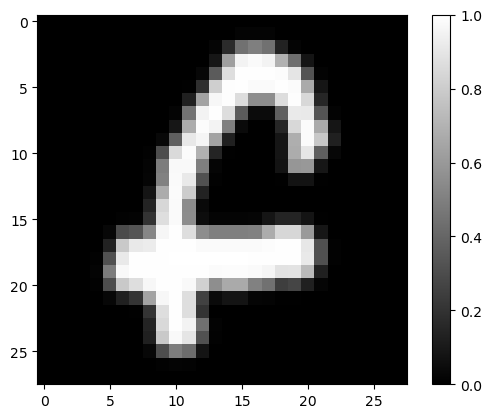

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(x_train[100].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.grid(False)

In [21]:
import numpy as np
import time

def ReLU(x, derivative=False):
    return x * (x > 0) if not derivative else x > 0


def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=1, keepdims=True)

class Network:

    def __init__(self, sizes, activation_func=ReLU, output_func=softmax):
        self.sizes = sizes
        self.activation_func = activation_func
        self.output_func = output_func
        # self._norm_init()
        # self._xavier_init()
        self._he_init()

    def _norm_init(self):
        
        self.weights = []
        self.biases = []
        self.activations = []
        self.deltaW = []
        self.deltaB = []
        
        for i in range(1, len(self.sizes)):
            self.weights.append(0 + 0.5 * np.random.randn(self.sizes[i-1], self.sizes[i]))
            self.biases.append(np.zeros((1, self.sizes[i])))

    def _xavier_init(self):
        
        self.weights = []
        self.biases = []
        self.activations = []
        self.deltaW = []
        self.deltaB = []
        
        for i in range(1, len(self.sizes)):
            left, right = self.sizes[i-1], self.sizes[i]
            limit = np.sqrt(6 / (left + right))
            self.weights.append(np.random.uniform(-limit, limit, size=(left, right)))
            self.biases.append(np.zeros((1, self.sizes[i])))
            
    def _he_init(self):
        self.weights = []
        self.biases = []
        self.activations = []
        self.deltaW = []
        self.deltaB = []
        
        for i in range(1, len(self.sizes)):
            left, right = self.sizes[i-1], self.sizes[i]
            limit = np.sqrt(2 / left)
            self.weights.append(np.random.uniform(-limit, limit, size=(left, right)))
            self.biases.append(np.zeros((1, self.sizes[i])))
       
    def _forward(self, x):
        self.activations = [np.array(x).reshape(1, len(x))]
        
        for i in range(len(self.sizes)-2):
            self.activations.append(self.activation_func(np.dot(self.activations[-1], self.weights[i]) + self.biases[i]))

        self.activations.append(self.output_func(np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]))
        
        return self.activations[-1]

    def _backprop(self, y_valid):
        self.deltaW = []
        self.deltaB = []
        error = self.activations[len(self.sizes)-1] - y_valid
        
        for i in range(len(self.sizes)-2, -1, -1):
            self.deltaW.insert(0, np.dot(self.activations[i].T, error))
            self.deltaB.insert(0, np.sum(error, axis=0, keepdims=True))
            error = np.dot(error, self.weights[i].T) * ReLU(self.activations[i], derivative=True)

    def _update_params(self, learning_rate):
        
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * self.deltaW[i]
            self.biases[i] -= learning_rate * self.deltaB[i]
        
    def _onehot(self, y):
        one_hot = np.zeros((1, self.sizes[-1]))
        one_hot[0, y] = 1
        return one_hot
        
    def fit(self, x_train, y_train, x_test, y_test, epochs, learning_rate):
        time_data = []
        loss_data = []
        acc_data = []
        start = time.time()
        for epoch in range(epochs):
            total_loss = 0
            epoch_start = time.time()
            for x, y in zip(x_train, y_train):
                y_onehot = self._onehot(y)
                self._forward(x)
                self._backprop(y_onehot)
                self._update_params(learning_rate)
                self._forward(x)
                output = self.activations[-1]
                loss = -np.sum(y_onehot * np.log(output + 1e-8))
                total_loss += loss
            avg_loss = total_loss / len(x_train)
            loss_data.append(avg_loss)
            print(f"====================================\n"
                  f"Epoch {epoch + 1}/{epochs}\nLoss: {avg_loss:.4f}")
            accuracy = self.test(x_test, y_test)
            acc_data.append(accuracy)
            print(f'Accuracy: {accuracy:.2f}%')
            time_data.append(time.time() - epoch_start)
        print(f'====================================\n'
              f'Total time: {time.time() - start:.2f}')
        
        return time_data, loss_data, acc_data
    
    def test(self, x_test, y_test):
        correct = 0
        for x, y in zip(x_test, y_test):
            prediction = self.predict(x)
            if prediction == y:
                correct += 1

        return correct / len(y_test) * 100

    def predict(self, x):
        self._forward(x)
        return np.argmax(self.activations[-1])

In [61]:
input_ = x_train.shape[1]  # размерность входных данных
hidden1 = 256
hidden2 = 128
output = len(np.unique(y_train))  # количество классов
model = Network([input_, hidden1, hidden2, output])

In [62]:
time_data, loss_data, acc_data = model.fit(x_train, y_train, x_test[:len(x_test)//2], y_test[:len(y_test)//2], epochs=10, learning_rate=0.01)

Epoch 1/10
Loss: 0.1488
Accuracy: 82.82%
Epoch 2/10
Loss: 0.0681
Accuracy: 84.87%
Epoch 3/10
Loss: 0.0565
Accuracy: 85.92%
Epoch 4/10
Loss: 0.0502
Accuracy: 85.21%
Epoch 5/10
Loss: 0.0463
Accuracy: 86.10%
Epoch 6/10
Loss: 0.0435
Accuracy: 85.14%
Epoch 7/10
Loss: 0.0412
Accuracy: 84.85%
Epoch 8/10
Loss: 0.0400
Accuracy: 86.06%
Epoch 9/10
Loss: 0.0380
Accuracy: 85.31%
Epoch 10/10
Loss: 0.0382
Accuracy: 86.50%
Total time: 891.18


In [63]:
time_data2, loss_data2, acc_data2 = model.fit(x_train, y_train, x_test[:len(x_test)//2], y_test[:len(y_test)//2], epochs=5, learning_rate=0.02)

Epoch 1/5
Loss: 0.1162
Accuracy: 77.47%
Epoch 2/5
Loss: 0.1370
Accuracy: 77.63%
Epoch 3/5
Loss: 0.1553
Accuracy: 80.12%
Epoch 4/5
Loss: 0.1718
Accuracy: 80.38%
Epoch 5/5
Loss: 0.1831
Accuracy: 80.28%
Total time: 425.49


In [64]:
time_data3, loss_data3, acc_data3 = model.fit(x_train, y_train, x_test[:len(x_test)//2], y_test[:len(y_test)//2], epochs=5, learning_rate=0.01)

Epoch 1/5
Loss: 0.1360
Accuracy: 85.63%
Epoch 2/5
Loss: 0.1082
Accuracy: 87.26%
Epoch 3/5
Loss: 0.0949
Accuracy: 87.74%
Epoch 4/5
Loss: 0.0879
Accuracy: 87.69%
Epoch 5/5
Loss: 0.0819
Accuracy: 87.69%
Total time: 420.91


Среднее время выполнения одной итерации: 86.88


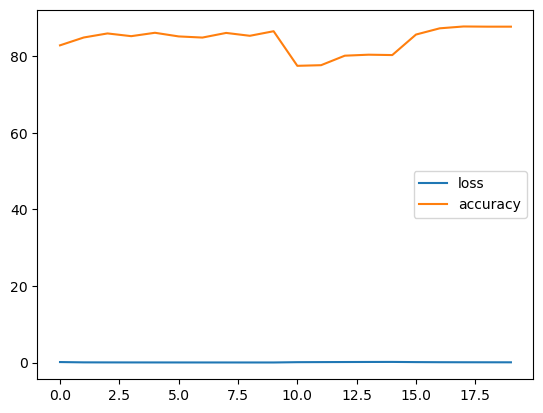

In [65]:
print(f'Среднее время выполнения одной итерации: {np.mean(np.concatenate((time_data, time_data2, time_data3), axis=None)):.2f}')
x_i = [i for i in range(20)]
plt.plot(x_i, np.concatenate((loss_data, loss_data2, loss_data3), axis=None), label='loss')
plt.plot(x_i, np.concatenate((acc_data, acc_data2, acc_data3), axis=None), label='accuracy')
plt.legend()
plt.show()

In [66]:
print(f'Validation...')
x_valid = x_test[len(x_test)//2:]
y_valid = y_test[len(y_test)//2:]
valid_accuracy = model.test(x_test[len(x_test)//2:], y_test[len(y_test)//2:])
print(f'Accuracy: {valid_accuracy:.2f}%')

Validation...
Accuracy: 90.38%


In [67]:
def visualize(images, predictions, real, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f'Prediction: {chr(idx[str(predictions[i])])}\nActual: {chr(idx[str(real[i])])}')
        axes[i].axis('off')
    plt.show()

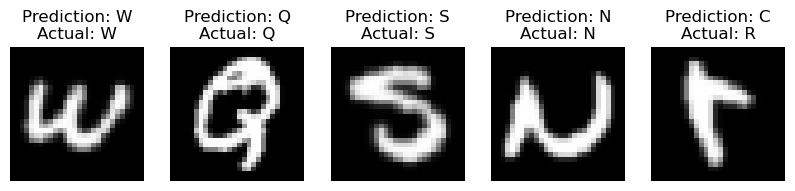

In [69]:
predictions = []
count = 5
x = []
y = []
for i in range(count):
    i_x = np.random.randint(0, x_valid.shape[0])
    x.append(x_valid[i_x])
    y.append(y_valid[i_x])
    predictions.append(model.predict(x_valid[i_x]))
visualize(x, predictions, y, count)